# Hyper parameters

In [279]:
DAYS_FUTURE = 50
DAYS_PAST = 50

HP_UNITS = 200
HP_LAYERS = 3

TRAIN_START = "2015-01-01"
TRAIN_END = "2020-01-01"

TEST_START = "2020-01-01"
TEST_END = "2021-01-01"

HP_DROPOUT = 0.4
HP_LR = 0.001
HP_BATCH_SIZE = 32
HP_EPOCHS = 350

# labels = ['next1', 'next2', 'next3']
labels = ['next1']
SPREAD = 0.00000

INIT_DEPOSIT = 1000


In [280]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline


# Get Data

In [281]:
import quandl as q 

In [282]:
q.ApiConfig.api_key = '11sy5SMsFERx_YypjsMi'

In [308]:
data = q.get('BITFINEX/BTCUSD') 

In [336]:
import os
from binance.client import Client

client = Client('ECKmhCpRn2Wp3hL8J5ae6hIyXWl6nwMCInT8h4UI0dbUVeNngeyu9Zv7UAcOoBfs',
                '9pqP4wgHObK9W8WwUkT29zfTg8wZ1d84gAvnWwT8M6bHt4FY1ysFvNnTTMUZRh0P')

# get latest price from Binance API
btc_price = client.get_symbol_ticker(symbol="BTCUSDT")

# print full output (dictionary)
print(btc_price)


{'symbol': 'BTCUSDT', 'price': '63329.45000000'}


In [337]:
bars = client.get_historical_klines('BTCUSDT', '30m',  "2021-01-01", "2021-11-01")


In [338]:
from datetime import datetime

for line in bars:
    del line[2:]

data = pd.DataFrame(bars, columns=['Date', 'Last'])
data['Date'] = pd.to_datetime(data['Date'], unit='ms')
data['Last'] = pd.to_numeric(data['Last'])

data.set_index('Date', inplace=True)
data.to_csv('btc_bars30.csv')


In [339]:
data

,Last
Date,
2021-01-01 00:00:00,28923.63
2021-01-01 00:30:00,28836.63
2021-01-01 01:00:00,28995.13
2021-01-01 01:30:00,29387.07
2021-01-01 02:00:00,29410.00
...,...
2021-10-31 22:00:00,61444.34
2021-10-31 22:30:00,61485.77
2021-10-31 23:00:00,61365.72


<AxesSubplot:xlabel='Date'>

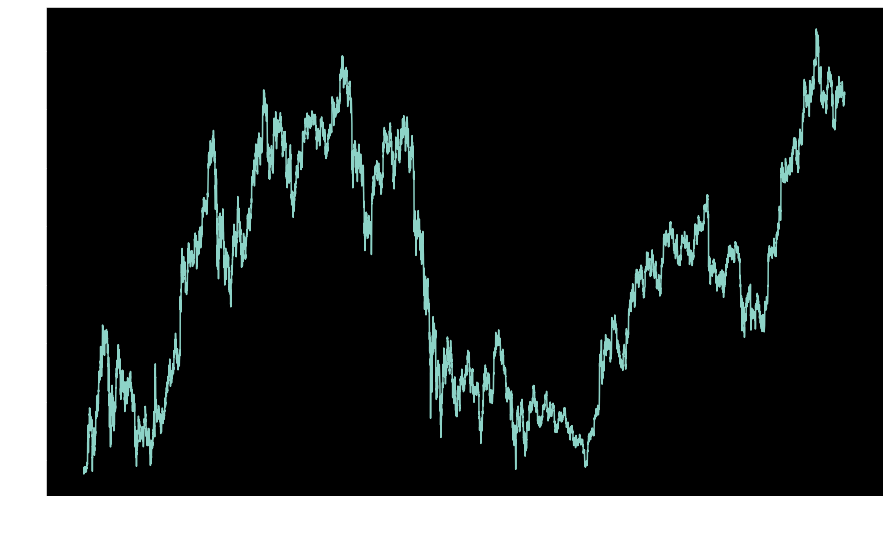

In [340]:
# show candles
data['Last'].plot(figsize=(15, 10))


# Create features

In [341]:
for i in range(1, INTERVALS_PAST):
    data['prev' + str(i)] = np.log(data['Last'] / data['Last'].shift(i))


In [342]:
for i in range(1, INTERVALS_FUTURE):
    data['next' + str(i)] = np.log(data['Last'] / data['Last'].shift(-i))


In [343]:
data

,Last,prev1,prev2,prev3,prev4,prev5,prev6,prev7,prev8,prev9,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,28923.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003638,-0.009942,-0.009543,-0.010393,-0.008248,-0.011935,-0.011642,-0.012117,-0.014010,-0.003748
2021-01-01 00:30:00,28836.63,-0.003012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.012954,-0.012555,-0.013405,-0.011260,-0.014947,-0.014654,-0.015130,-0.017022,-0.006760,-0.012451
2021-01-01 01:00:00,28995.13,0.005481,0.002469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.007074,-0.007924,-0.005779,-0.009466,-0.009173,-0.009648,-0.011541,-0.001279,-0.006970,-0.007330
2021-01-01 01:30:00,29387.07,0.013427,0.018908,0.015896,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005503,0.007648,0.003961,0.004254,0.003779,0.001886,0.012148,0.006457,0.006097,0.000940
2021-01-01 02:00:00,29410.00,0.000780,0.014207,0.019688,0.016676,NaN,NaN,NaN,NaN,NaN,...,0.008428,0.004741,0.005034,0.004558,0.002666,0.012928,0.007237,0.006877,0.001720,-0.000147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 22:00:00,61444.34,0.004384,0.008531,0.007881,0.012354,0.011014,0.012095,0.016151,0.013599,0.008789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31 22:30:00,61485.77,0.000674,0.005058,0.009205,0.008555,0.013028,0.011688,0.012769,0.016825,0.014273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31 23:00:00,61365.72,-0.001954,-0.001280,0.003104,0.007251,0.006600,0.011073,0.009734,0.010815,0.014871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Model create

In [344]:
import tensorflow as tf


In [345]:
# create an MLP model
def create_model(input_shape, output_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HP_UNITS,
              activation='relu', input_shape=input_shape))
    for a in range(HP_LAYERS):
        model.add(tf.keras.layers.Dense(units=HP_UNITS, activation='relu'))
        if a != HP_LAYERS:
            model.add(tf.keras.layers.Dropout(HP_DROPOUT))

    model.add(tf.keras.layers.Dense(units=output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        HP_LR), metrics=["accuracy"])
    return model


# Split to train set and test set

In [346]:
X_train = data.loc[(data.index >= TRAIN_START) &
                   (data.index <= TRAIN_END)]
X_test = data.loc[(data.index >= TEST_START) &
                  (data.index <= TEST_END)]


In [347]:

y_train = X_train[labels].to_numpy()  # X - source, y - target
y_test = X_test[labels].to_numpy()


In [348]:
columns = []
for i in range(1, INTERVALS_PAST):
    columns.append('prev' + str(i))


In [349]:
X_train = X_train[columns].to_numpy()
X_test_times = X_test.index
X_test_price = X_test['Last'].to_numpy()
X_test = X_test[columns].to_numpy()


In [350]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train), y_train))
train_ds = train_ds.take(len(X_train))
test_ds = tf.data.Dataset.from_tensor_slices(((X_test), y_test))
test_ds = test_ds.take(len(X_test))
train_ds = train_ds.batch(HP_BATCH_SIZE, False).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(len(X_test), False).prefetch(tf.data.AUTOTUNE)


In [351]:
X_train.shape

(13074, 49)

In [352]:
X_test.shape

(1489, 49)

In [353]:
model = create_model(X_test[0].shape, len(y_test[0]))


# Training model

In [354]:
callback_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=HP_BATCH_SIZE,
    # callbacks=[callback_early],
    verbose=2, epochs=HP_EPOCHS)


Epoch 1/10
26/26 - 1s - loss: nan - accuracy: 0.3775 - val_loss: nan - val_accuracy: 0.3761
Epoch 2/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761
Epoch 3/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761
Epoch 4/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761
Epoch 5/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761
Epoch 6/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761
Epoch 7/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761
Epoch 8/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761
Epoch 9/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761
Epoch 10/10
26/26 - 0s - loss: nan - accuracy: 0.3814 - val_loss: nan - val_accuracy: 0.3761


In [355]:
# helper functions to plot accuracy and loss
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [356]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


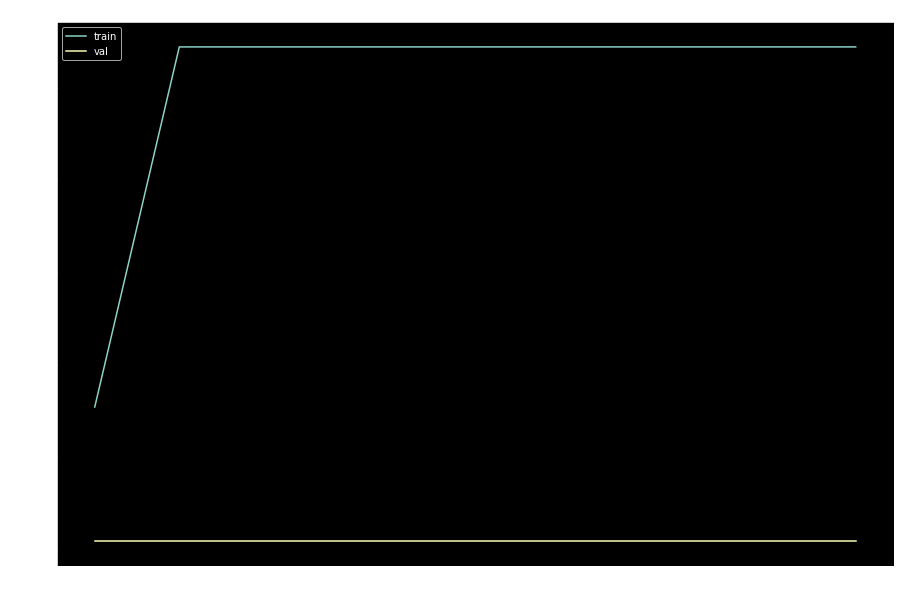

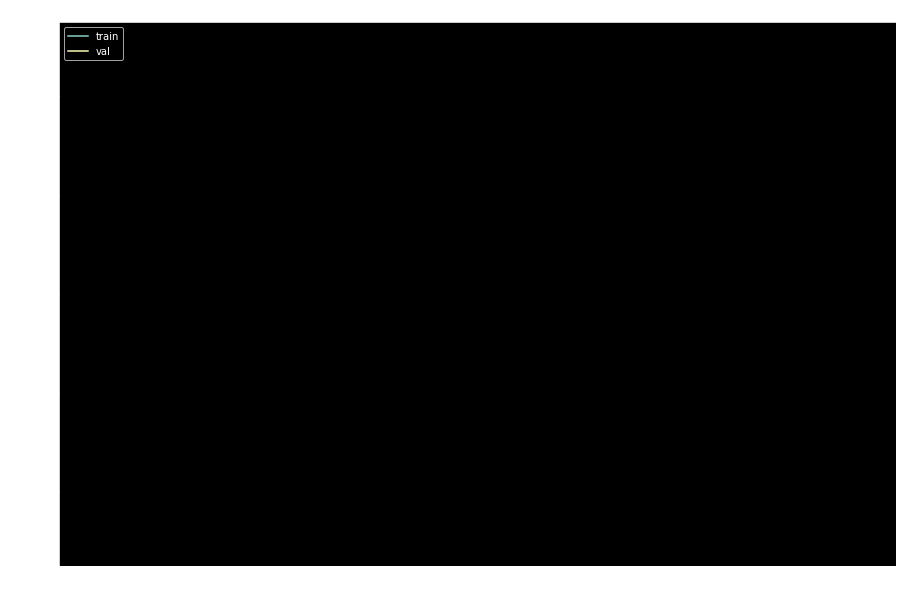

In [357]:
plt.figure(figsize=(15, 10))
plot_accuracy(history)
plt.figure(figsize=(15, 10))
plot_loss(history)


# Trains results

In [358]:
train_prediction = model.predict(X_train)


In [359]:

from sklearn.metrics import mean_absolute_error

train_mse = mean_absolute_error(y_train, train_prediction)
round(train_mse, 5)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
for i in range(len(labels)):
    print (labels[i],   "{:8.5f}".format(mean_absolute_error(y_train[:,i], train_prediction[:,i])))  

next1  0.03449
next2  0.04821
next3  0.05987


In [ ]:
best = 0

for j in range(len(labels)):
    c = 0
    n = 0
    for i in range(len(y_train)):
        if abs(train_prediction[i, j]) < 0.00001:
            continue
        n = n+1
        if (np.sign(y_train[i, j]) == np.sign(train_prediction[i, j])):
            c = c+1
    print(labels[j], round(c/n, 3))
    if c/n > best:
        best = c/n
        best_label = j

labels[best_label]


next1 0.451
next2 0.484
next3 0.526


'next3'

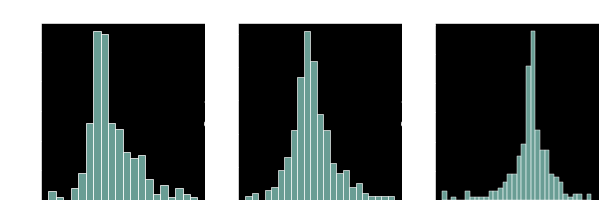

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    sns.histplot(data=train_prediction[:, i])


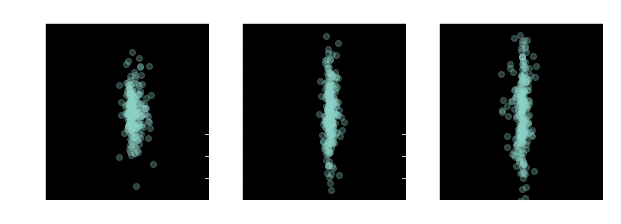

In [ ]:
fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])

    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.2, 0.2)
    plt.scatter(train_prediction[:, i], y_train[:, i], alpha=0.3)


# Test results

In [ ]:
test_prediction=model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error

test_mse = mean_absolute_error(y_test, test_prediction)
round(train_mse,5)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
for i in range(len(labels)):
    print (labels[i],   "{:8.5f}".format(mean_absolute_error(y_test[:,i], test_prediction[:,i])))  

next1  0.02551
next2  0.03640
next3  0.04626


In [ ]:
best = 0

for j in range(len(labels)):
    c = 0
    n = 0
    for i in range(len(y_test)):
        if abs(test_prediction[i, j]) < 0.00001:
            continue
        n = n+1
        if (np.sign(y_test[i, j]) == np.sign(test_prediction[i, j])):
            c = c+1
    print(labels[j], round(c/n, 3))
    if c/n > best:
        best = c/n
        best_label = j

labels[best_label]


next1 0.555
next2 0.609
next3 0.598


'next2'

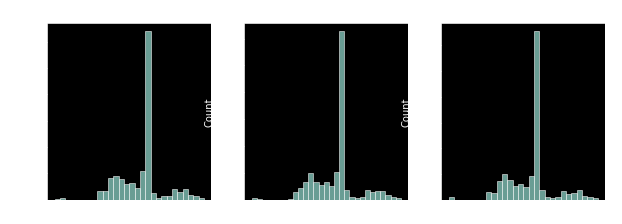

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    sns.histplot(data=test_prediction[:, i])


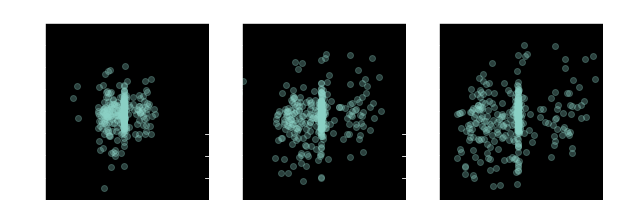

In [ ]:
fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.2, 0.2)
    plt.scatter(test_prediction[:, i], y_test[:, i], alpha=0.3)


# Backtesting

In [ ]:
summer = lambda y: sum(y)/len(labels)
test_sum = np.array([summer(y) for y in test_prediction])


In [ ]:
data = pd.DataFrame({'Datetime': X_test_times, 'distance': test_sum, 'Last': X_test_price })


In [ ]:
def run_strategy(a_data, threshold):
    ''' Backtests the trading strategy.
    '''
    data = a_data.copy().dropna()
    data['returns'] = np.log(data['Last'] / data['Last'].shift(1)).dropna()
    # buy BTC signals
    data['position'] = np.where(data['distance'] > threshold, 1, np.nan)
    # sell BTC signals
    data['position'] = np.where(data['distance'] < -threshold, -1,
                                data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    data['strategy'] = data['position'].shift(1) * data['returns']
    # determine when a trade takes place
    trades = data['position'].diff().fillna(0) != 0
    # subtract transaction costs from return when trade takes place
    data['strategy'][trades] -= SPREAD
    data['buy'] = data['position'].diff().fillna(0) > 0
    data['sell'] = data['position'].diff().fillna(0) < 0
    data['creturns'] = INIT_DEPOSIT * data['returns'].cumsum().apply(np.exp)
    data['cstrategy'] = INIT_DEPOSIT * data['strategy'].cumsum().apply(np.exp)
    results = data
    # absolute performance of the strategy
    aperf = results['cstrategy'].iloc[-1]
    # base instrument performance (BTC)
    bperf = results['creturns'].iloc[-1]
    # out-/underperformance of strategy
    operf = aperf - bperf

    return round(aperf, 2), round(operf, 2), results


In [ ]:

best_threshold = 0
best_aperf = 0
for i in range(100):
    x, y, z = run_strategy(data, i/100)
    print(i/100, x)
    if x > best_aperf:
        best_aperf = x
        best_threshold = i/100


0.0 117.06
0.01 412.73
0.02 335.43
0.03 264.53
0.04 384.79
0.05 489.15
0.06 3796.91
0.07 196.79
0.08 196.79
0.09 196.79
0.1 196.79
0.11 1000.0
0.12 1000.0
0.13 1000.0
0.14 1000.0
0.15 1000.0
0.16 1000.0
0.17 1000.0
0.18 1000.0
0.19 1000.0
0.2 1000.0
0.21 1000.0
0.22 1000.0
0.23 1000.0
0.24 1000.0
0.25 1000.0
0.26 1000.0
0.27 1000.0
0.28 1000.0
0.29 1000.0
0.3 1000.0
0.31 1000.0
0.32 1000.0
0.33 1000.0
0.34 1000.0
0.35 1000.0
0.36 1000.0
0.37 1000.0
0.38 1000.0
0.39 1000.0
0.4 1000.0
0.41 1000.0
0.42 1000.0
0.43 1000.0
0.44 1000.0
0.45 1000.0
0.46 1000.0
0.47 1000.0
0.48 1000.0
0.49 1000.0
0.5 1000.0
0.51 1000.0
0.52 1000.0
0.53 1000.0
0.54 1000.0
0.55 1000.0
0.56 1000.0
0.57 1000.0
0.58 1000.0
0.59 1000.0
0.6 1000.0
0.61 1000.0
0.62 1000.0
0.63 1000.0
0.64 1000.0
0.65 1000.0
0.66 1000.0
0.67 1000.0
0.68 1000.0
0.69 1000.0
0.7 1000.0
0.71 1000.0
0.72 1000.0
0.73 1000.0
0.74 1000.0
0.75 1000.0
0.76 1000.0
0.77 1000.0
0.78 1000.0
0.79 1000.0
0.8 1000.0
0.81 1000.0
0.82 1000.0
0.83 1000.0


In [ ]:
run_strategy(data, best_threshold)


(3796.91,
 -266.69,
       Datetime  distance       Last   returns  position  strategy    buy  \
 0   2020-01-01 -0.003462   7213.100       NaN       0.0       NaN  False   
 1   2020-01-02  0.041466   6989.500 -0.031490       0.0 -0.000000  False   
 2   2020-01-03  0.035360   7356.900  0.051230       0.0  0.000000  False   
 3   2020-01-04  0.026036   7373.000  0.002186       0.0  0.000000  False   
 4   2020-01-05  0.004026   7344.900 -0.003818       0.0 -0.000000  False   
 ..         ...       ...        ...       ...       ...       ...    ...   
 361 2020-12-28 -0.024628  27094.000  0.026668       1.0  0.026668  False   
 362 2020-12-29 -0.030823  27228.000  0.004934       1.0  0.004934  False   
 363 2020-12-30 -0.006082  28805.000  0.056303       1.0  0.056303  False   
 364 2020-12-31 -0.004885  28948.000  0.004952       1.0  0.004952  False   
 365 2021-01-01 -0.021587  29311.114  0.012466       1.0  0.012466  False   
 
       sell     creturns    cstrategy  
 0    False   